In [1]:
# Low Volatility Portfolio Optimization

import numpy as np
import pandas as pd
import pyfolio as pf
from matplotlib import pyplot as plt
from colorhash import ColorHash

from FundSelection import FundSelection
from Portfolio import Portfolio

PORTFOLIO_YEARS = 6
N_DAYS = 252  # trading days in a year
N_PORTFOLIOS = 1000000
RISK_FREE_RATE = 0.0375  # 3.75%  

abridged_fund_selection = [
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc'),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc'),
    FundSelection('JPM Europe Equity Absolute Alpha C (perf) (dist) - GBP (hedged)'),
    FundSelection('Man High Yield Opports Profl Acc C'), 
]

# Only 3 years of data, so proxy early years with the best Sharpe ratio weghtings from the other funds
man_dynamic_income = FundSelection('Man Dynamic Income I H GBP Cap', proxy_funds=abridged_fund_selection)

full_fund_selection = abridged_fund_selection + [
    man_dynamic_income
]


abridged_fund_names = [fund.name for fund in abridged_fund_selection]
full_fund_names = [fund.name for fund in full_fund_selection]

benchmark = [
    FundSelection('Ranmore Global Equity Investor GBP', 0.25),
    FundSelection('L&G Global 100 Index I Acc', 0.13, proxy_funds=[FundSelection('Fidelity Global Technology W-Acc-GBP', 1.0)]),
    FundSelection('MFS Meridian Contrarian Value W1 GBP', 0.06),
    FundSelection('FAST - Global Fund Y-PF-ACC-GBP', 0.06),
    FundSelection('YFS Argonaut Absolute Return I GBP Acc', 0.10),
    FundSelection('BH Macro GBP Ord', 0.10),
    FundSelection('WisdomTree Physical Gold GBP Daily Hdgd', 0.10),
    FundSelection('Winton Trend UCITS I GBP Acc', 0.05),
    FundSelection('iShares Blmbrg Enh Roll Yld Cmd Swap ETF GBP',0.05),
    FundSelection('JupiterMerian Glb Eq AbsRt I £ H Acc', 0.05),
    FundSelection('Prem Miton Tellworth UK Sel Fd - Cl AAcc', 0.05)
]

abridged_portfolio = Portfolio(abridged_fund_selection, benchmark, PORTFOLIO_YEARS)
abridged_returns_df = abridged_portfolio.adjusted_returns
abridged_avg_returns = abridged_returns_df.mean() * N_DAYS
abridged_cov_mat = abridged_returns_df.cov() * N_DAYS

C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Generate N_PORTFOLIOS random portfolios by weighting into Abridged portfolio
# Use the weights of this portfolio to backfill the Man Dynamic Income fund in the full portfolio

np.random.seed(42)

# Abridged Portfolio
abridged_weights = np.random.random(size=(N_PORTFOLIOS, len(abridged_fund_selection)))
abridged_weights /= np.sum(abridged_weights, axis=1)[:, np.newaxis]

abridged_portf_rtns = np.dot(abridged_weights, abridged_avg_returns)
abridged_portf_vol = []

# Monte Carlo
for i in range(0, len(abridged_weights)):
    abridged_portf_vol.append(np.sqrt(np.dot(abridged_weights[i].T, np.dot(abridged_cov_mat, abridged_weights[i]))))

abridged_portf_vol = np.array(abridged_portf_vol)
abridged_portf_sharpe_ratio = (abridged_portf_rtns - RISK_FREE_RATE) / abridged_portf_vol

abridged_portf_results_df = pd.DataFrame({'returns': abridged_portf_rtns,
                                 'volatility': abridged_portf_vol,
                                 'sharpe_ratio': abridged_portf_sharpe_ratio})

#Calculate the efficient frontier and highest Sharpe ratio portfolio using scipy.optimize

import scipy.optimize as sco

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_rtns)
    args = (avg_rtns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

# Calculate the efficient frontier to 'efficient_portfolios' variable using scipy.optimize
rtns_range = np.linspace(start=0.07, stop=0.13, num=200)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})

# Abridged Portfolio - calculate max Sharpe Ration Portfolio and associated weights
abridged_efficient_portfolios = get_efficient_frontier(abridged_avg_returns, abridged_cov_mat, rtns_range)
abridged_vols_range = [x['fun'] for x in abridged_efficient_portfolios]
abridged_n_assets = len(abridged_avg_returns)
abridged_args = (abridged_avg_returns, abridged_cov_mat, RISK_FREE_RATE)
abridged_bounds = tuple((0,1) for asset in range(abridged_n_assets))
abridged_initial_guess = abridged_n_assets * [1. / abridged_n_assets]
abridged_max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=abridged_initial_guess,
                                args=abridged_args,
                                method='SLSQP',
                                bounds=abridged_bounds,
                                constraints=constraints)
abridged_max_sharpe_portf_weights = abridged_max_sharpe_portf['x']
abridged_max_sharpe_portf = {'Return': get_portf_rtn(abridged_max_sharpe_portf_weights, abridged_avg_returns),
                    'Volatility': get_portf_vol(abridged_max_sharpe_portf_weights, abridged_avg_returns, abridged_cov_mat),
                    'Sharpe Ratio': -abridged_max_sharpe_portf['fun'],
                    'Weights': abridged_max_sharpe_portf_weights}

# update weights in abridged_fund_selection, this also updates the proxy funds in full_fund_selection
for i in range(len(abridged_fund_names)):
    abridged_fund_selection[i].weight = abridged_max_sharpe_portf['Weights'][i]

In [3]:
#Full Portfolio - 1st 3 years of Man Dynamic Income fund backfilled with the proxy fund weights from the abridged portfolio
full_portfolio = Portfolio(full_fund_selection, benchmark, PORTFOLIO_YEARS)

full_returns_df = full_portfolio.adjusted_returns
full_avg_returns = full_returns_df.mean() * N_DAYS
full_cov_mat = full_returns_df.cov() * N_DAYS

full_weights = np.random.random(size=(N_PORTFOLIOS, len(full_fund_selection)))
full_weights /= np.sum(full_weights, axis=1)[:, np.newaxis]

full_portf_rtns = np.dot(full_weights, full_avg_returns)
full_portf_vol = []

for i in range(0, len(full_weights)):
    full_portf_vol.append(np.sqrt(np.dot(full_weights[i].T, np.dot(full_cov_mat, full_weights[i]))))

full_portf_vol = np.array(full_portf_vol)
full_portf_sharpe_ratio = (full_portf_rtns - RISK_FREE_RATE) / full_portf_vol

full_portf_results_df = pd.DataFrame({'returns': full_portf_rtns,
                                 'volatility': full_portf_vol,
                                 'sharpe_ratio': full_portf_sharpe_ratio})

full_efficient_portfolios = get_efficient_frontier(full_avg_returns, full_cov_mat, rtns_range)
full_vols_range = [x['fun'] for x in full_efficient_portfolios]
full_n_assets = len(full_avg_returns)
full_args = (full_avg_returns, full_cov_mat, RISK_FREE_RATE)
full_bounds = tuple((0,1) for asset in range(full_n_assets))
full_initial_guess = full_n_assets * [1. / full_n_assets]
full_max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=full_initial_guess,
                                args=full_args,
                                method='SLSQP',
                                bounds=full_bounds,
                                constraints=constraints)
full_max_sharpe_portf_weights = full_max_sharpe_portf['x']
full_max_sharpe_portf = {'Return': get_portf_rtn(full_max_sharpe_portf_weights, full_avg_returns),
                    'Volatility': get_portf_vol(full_max_sharpe_portf_weights, full_avg_returns, full_cov_mat),
                    'Sharpe Ratio': -full_max_sharpe_portf['fun'],
                    'Weights': full_max_sharpe_portf_weights}

C:\Users\Pandelus\AppData\Local\Temp\ipykernel_26348\1921304102.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=full_avg_returns[asset_index],


[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

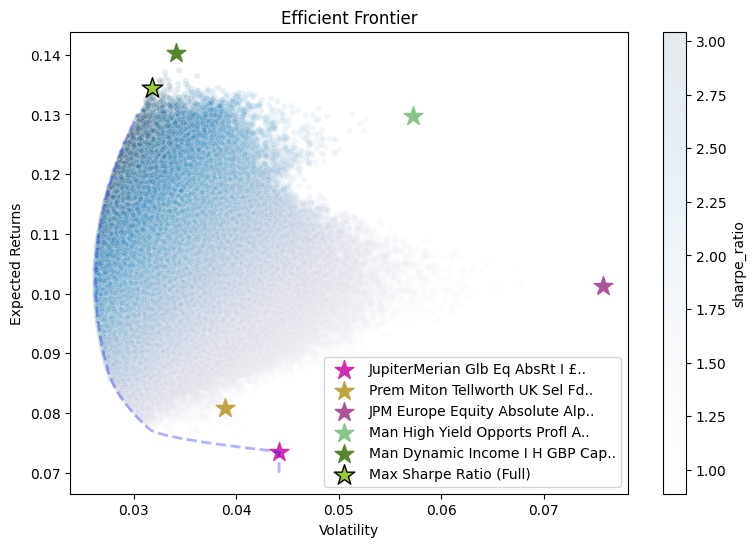

In [4]:
#Plot the calculated Efficient Frontier, together with the simulated portfolios

fig, ax = plt.subplots()
full_portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='PuBu', edgecolors='white',
                      figsize=(9, 6),
                      alpha=0.1,
                      ax=ax)

# draw the efficient frontier lines
ax.plot(full_vols_range, rtns_range, 'b--', linewidth=2, alpha=0.3)

# Add full individual funds    
for asset_index in range(len(full_fund_selection)):
    ax.scatter(x=np.sqrt(full_cov_mat.iloc[asset_index, asset_index]),
               y=full_avg_returns[asset_index],
               marker='*',
               s=200,
               alpha=1,
               color=ColorHash(full_fund_selection[asset_index].name).hex,
               label=full_fund_selection[asset_index].name[:30]+'..')

ax.scatter(x=full_max_sharpe_portf['Volatility'],   
           y=full_max_sharpe_portf['Return'],
           marker='*',
           s=240,
           alpha=1,
           color='yellowgreen', edgecolors='black', linewidths=1,
           label='Max Sharpe Ratio (Full)')    

ax.legend()

ax.set(xlabel='Volatility',ylabel='Expected Returns', title='Efficient Frontier')

In [5]:
# Backtest the maximum Sharpe ratio portfolio

import plotly.express as plot

full_weights = full_max_sharpe_portf['Weights']
graph_prices = full_portfolio.daily_price_history.copy()

names_with_weights = []
weight_colours=[]

for i in range(len(full_fund_names)):
    names_with_weights.append(f"{round(full_weights[i],4)*100.0:.2f}% - {full_fund_names[i][:30]+'..'}")
    colour = ColorHash(full_fund_names[i], lightness=[0.28]).hex
    weight_colours.append(colour)

graph_prices.columns = names_with_weights

# Add total to graph
title = f'Highest Sharpe Ratio ({full_max_sharpe_portf["Sharpe Ratio"]:.2f}) for given return portfolio {full_max_sharpe_portf["Return"]*100.0:.2f}% return'
total_prices = full_portfolio.daily_price_history.dot(full_max_sharpe_portf['Weights'])
graph_prices['Highest Sharpe Ratio for given return portfolio'] = total_prices
names_with_weights.append(title)
weight_colours.append("yellow")

# Add benchmark to graph
graph_prices['Benchmark (4PHUXACHE)'] = abridged_portfolio.get_benchmark_daily_price_history()
names_with_weights.append(f'Benchmark (4PHUXACHE)')
weight_colours.append("orange")

fig = plot.line(graph_prices, x=graph_prices.index, y=graph_prices.columns, 
                title=title,
                labels={'value': 'Price', 'variable': 'Instrument'},
                template='plotly_dark',
                color_discrete_sequence=weight_colours
                )
fig.update_layout(autosize=False, width=1200, height=800 )
fig.show()


In [84]:
# https://github.com/quantopian/pyfolio/blob/master/pyfolio/tears.py#L409

from pyfolio import utils, plotting
import empyrical as ep
import matplotlib.gridspec as gridspec

def create_returns_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    
    if benchmark_rets is not None:
        returns = utils.clip_returns_to_benchmark(returns, benchmark_rets)

    plotting.show_perf_stats(returns, benchmark_rets,
                             positions=positions,
                             transactions=transactions,
                             turnover_denom=turnover_denom,
                             bootstrap=bootstrap,
                             live_start_date=live_start_date,
                             header_rows=header_rows)

    plotting.show_worst_drawdown_periods(returns)

    vertical_sections = 11

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if benchmark_rets is not None:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 4))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)

    i = 2

    ax_rolling_returns = plt.subplot(gs[i, :-1])
    ax_annual_returns = plt.subplot(gs[i, 2])

    i+=1

    ax_drawdown = plt.subplot(gs[i, 0])
    ax_monthly_heatmap = plt.subplot(gs[i, 1])
    ax_returns = plt.subplot(gs[i, 2])

    i+=1 

    ax_underwater = plt.subplot(gs[i, 0])
    ax_monthly_dist = plt.subplot(gs[i, 1])
    ax_rolling_volatility = plt.subplot(gs[i, 2])
    i += 1

    plotting.plot_returns(returns, live_start_date=live_start_date, ax=ax_returns)
    ax_returns.set_title('Returns')

    plotting.plot_rolling_volatility(returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    # Drawdowns
    plotting.plot_drawdown_periods(returns, top=5, ax=ax_drawdown)
    plotting.plot_drawdown_underwater(returns=returns, ax=ax_underwater)

    plotting.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title('Cumulative returns')

    plotting.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    plotting.plot_annual_returns(returns, ax=ax_annual_returns)
    plotting.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    if return_fig:
        return fig


C:\Users\Pandelus\AppData\Roaming\Python\Python313\site-packages\pyfolio\plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.066%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Start date,2019-09-09
End date,2025-07-18
Total months,72
,Backtest
Annual return,14.066%
Cumulative returns,121.872%
Annual volatility,3.229%
Sharpe ratio,4.26
Calmar ratio,1.24
Stability,0.98
Max drawdown,-11.334%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.33,2020-02-17,2020-03-19,2020-07-23,114
1,4.19,2022-09-12,2022-10-14,2022-11-14,46
2,3.02,2023-03-10,2023-03-17,2023-05-04,40
3,2.85,2022-01-18,2022-07-06,2022-07-22,134
4,1.71,2025-04-02,2025-04-09,2025-05-13,30


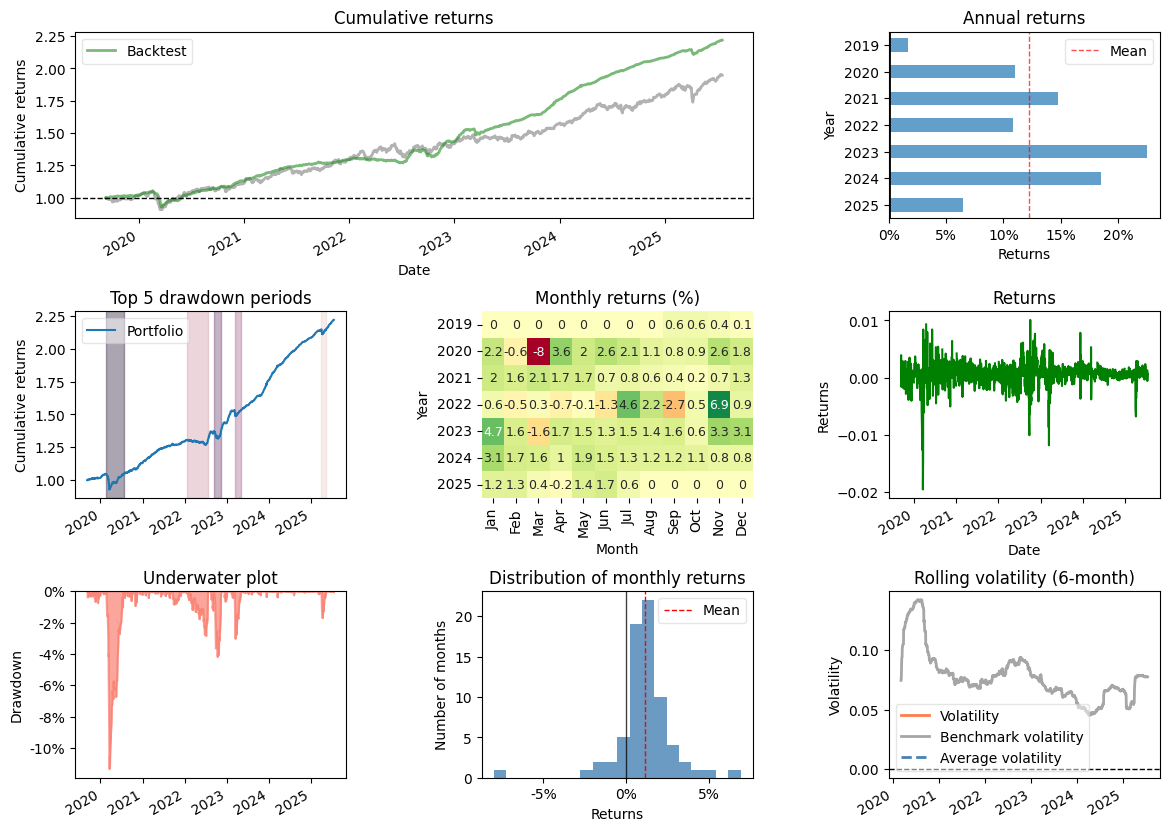

In [85]:
portfolio_returns = full_portfolio.adjusted_returns.dot(full_max_sharpe_portf['Weights'])
benchmark_weights = [f.weight for f in full_portfolio.benchmark]
benchmark_returns = full_portfolio.benchmark_adjusted_returns.dot(benchmark_weights)
create_returns_tear_sheet(portfolio_returns, benchmark_rets=benchmark_returns)
